In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ts_list = open("../010D_11455_131313/ts_377_360.txt").readlines()
ts_arr = np.loadtxt(fname = "../010D_11455_131313/ts_377_360.txt", skiprows=8, dtype="int, float")

In [3]:
ds = h5py.File("../010D_11455_131313/TS_GEOCml1GACOSmaskclip/cum_filt.h5", "r")
list(ds.keys())

['corner_lat',
 'corner_lon',
 'cum',
 'deramp_flag',
 'filtwidth_km',
 'filtwidth_yr',
 'gap',
 'hgt_linear_flag',
 'imdates',
 'post_lat',
 'post_lon',
 'refarea',
 'vel',
 'vintercept']

In [4]:
corner_lat = ds["corner_lat"][()]
corner_lon = ds["corner_lon"][()]
post_lat = ds["post_lat"][()]
post_lon = ds["post_lon"][()]
vel = ds["vel"][:,:]
extent = [corner_lon, 
          corner_lon + (post_lon*np.shape(vel)[1]), 
          corner_lat + (post_lat*np.shape(vel)[0]),
          corner_lat]

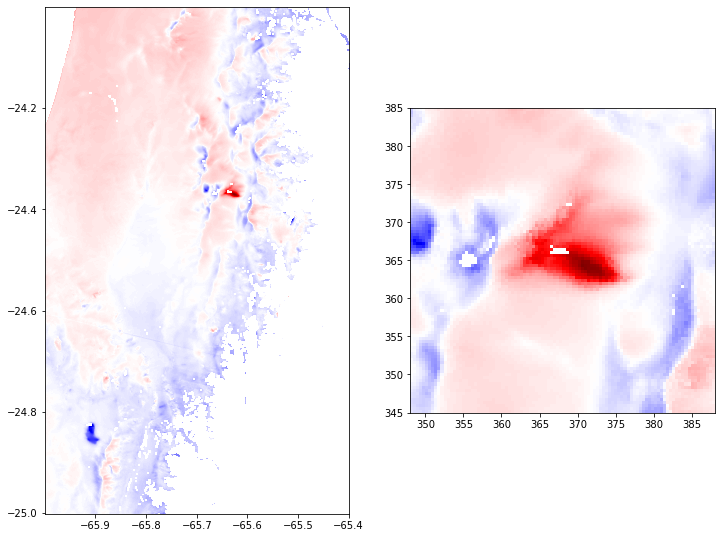

In [5]:
y, x = 368, 365
#y, x = 620, 276

fig, ax = plt.subplots(1, 2, figsize = (12,16))
ax[0].imshow(vel, extent=extent, cmap="seismic", vmin=-np.nanmax(vel))
ax[1].imshow(vel[y-50:y+50,x-50:x+50], cmap="seismic", vmax = np.nanmax(vel), vmin=-np.nanmax(vel), extent=[y-20,y+20,x-20,x+20])

In [6]:
def date2delta(d0, d):
    delta = d - d0
    return delta.days

In [7]:
t_min = 0
ts_dict = {
"dates" : ds["imdates"][t_min:],
"data" : ds["cum"][t_min:,y,x]}
ts = pd.DataFrame(ts_dict, index=ts_dict["dates"])
ts.dates = pd.to_datetime(ts.index, format="%Y%m%d")
ts["year"] = ts.apply(lambda x: x.dates.year, axis=1)
ts["month"] = ts.apply(lambda x: x.dates.month, axis=1)
ts["day_of_year"] = ts.apply(lambda x: x.dates.strftime("%j"), axis=1)

ts["days"] = ts.apply(lambda x: date2delta(ts.dates.min(), x.dates), axis=1)

In [8]:
ts.head()

,dates,data,year,month,day_of_year,days
20141018,2014-10-18,6.486027,2014,10,291,0
20141111,2014-11-11,23.665676,2014,11,315,24
20141205,2014-12-05,6.310331,2014,12,339,48
20141229,2014-12-29,28.065586,2014,12,363,72
20150122,2015-01-22,7.576437,2015,1,022,96


In [9]:
linear_reg_coef = np.polyfit(ts.days, ts.data, deg=1)
linear_reg = (linear_reg_coef[0]*ts.days) + linear_reg_coef[1]

linear_reg_coef

array([ 0.11357703, -5.80712144])

In [10]:
diff_detrend = []
ts_arr = ts.data.to_numpy()
for i in range(1, len(ts_arr)):
    diff_detrend.append(ts_arr[i] - ts_arr[i-1])

In [20]:
ts["diff_detrend"] = np.nan

ts["diff_detrend"].iloc[:-1] = diff_detrend
ts["regresion_rm"] = np.subtract(ts.data,linear_reg)

/home/student/.conda/envs/BigData/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


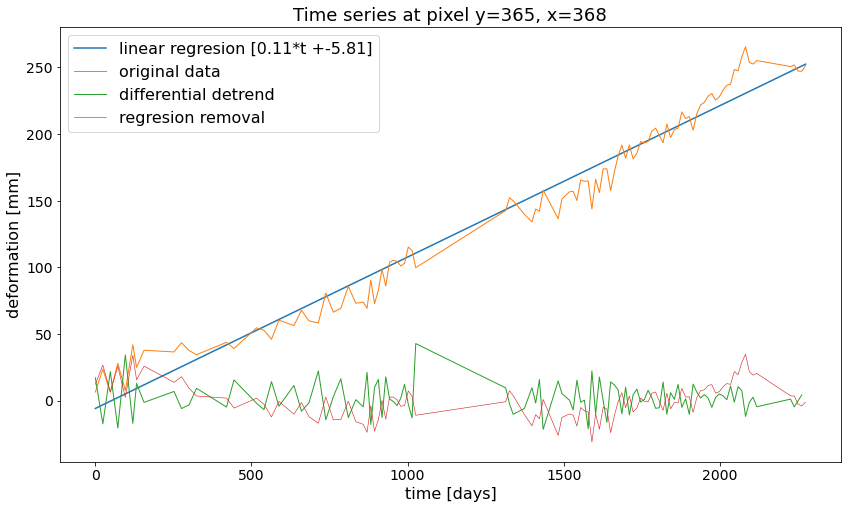

In [40]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(ts.days, linear_reg, 
        label="linear regresion [{:.2f}*t +{:.2f}]".format(linear_reg_coef[0], linear_reg_coef[1]))


ts.plot(x="days", y="data", ax=ax, label="original data", linewidth=1)
ts.plot(x="days", y="diff_detrend", ax=ax, label="differential detrend", linewidth=1)
ts.plot(x="days", y="regresion_rm", ax=ax, label="regresion removal", linewidth=0.6)

    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=16)
ax.set_ylabel("deformation [mm]", fontsize=16)
ax.set_xlabel("time [days]", fontsize=16)
ax.set_title("Time series at pixel y={}, x={}".format(x,y), fontsize=18)
plt.show()

For this pixel, the deformation rate is aprox 40.2mm/yr

In [12]:
linear_reg_coef_deg2 = np.polyfit(ts.days, ts.data, deg=3)
linear_reg_deg2 = ts.days**2 * linear_reg_coef_deg2[0] + \
                ts.days**2 * linear_reg_coef_deg2[1] + \
                ts.days * linear_reg_coef_deg2[2] + \
                linear_reg_coef_deg2[3]

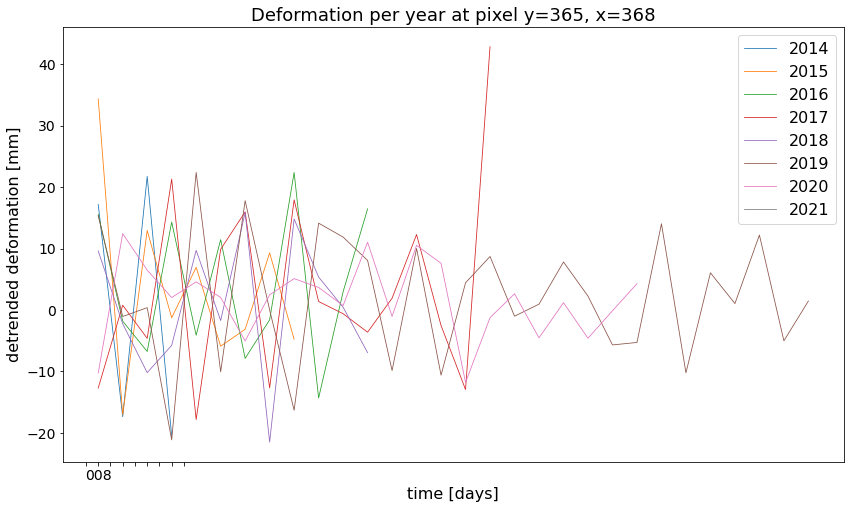

In [37]:
fig, ax = plt.subplots(figsize = (14,8))
for year in ts.year.unique():
    ts.loc[ts.year == year].plot(x="day_of_year", 
                                 y="diff_detrend", 
                                 ax=ax, label=year,
                                 linewidth=0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=16)
ax.set_ylabel("detrended deformation [mm]", fontsize=16)
ax.set_xlabel("time [days]", fontsize=16)
ax.set_title("Deformation per year at pixel y={}, x={}".format(x,y), fontsize=18)
plt.show()